In [1]:
import os
import pickle
import json
import pandas as pd
import numpy as np
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
rd_seed = 42

# plotting parameters
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size=15)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15, title_fontsize=15)
plt.rc('lines', linewidth=1, linestyle='-', markersize = 6)
plt.rc('axes', titlesize=15, labelsize = 15)

In [2]:
feature_set_names = ["B+S","B+S+CM","B+S+CM_all", "reduced"]
feature_set_labels = {
    "B+S":"B+S", 
    "B+S+CM":"B+S+CM",
    "B+S+CM_all": "B+S+$\mathrm{CM}_{\mathrm{all}}$",
    "reduced":"reduced"
}

In [3]:
def get_eval(validation_lof, test_true, test_lof):
    # TPR @ FPR
    FPR = 0.05
    n = validation_lof.shape[0]
    # get the threshold
    thr = -np.sort(-validation_lof)[int(np.round(FPR*n))]
    TPRatFPR = (test_lof[test_true == 1] >= thr).sum()/test_true.sum()
    print(f"  TPR at {100*FPR:.0f} FPR = {100*TPRatFPR:.1f}")
    # AUC
    roc_auc = metrics.roc_auc_score(test_true, test_lof, max_fpr = 0.1)
    print(f"  ROC AUC = {100*roc_auc:.1f}")

In [4]:
# load datasets
save_dir = os.path.join("../results/novelty")

train_datasets = {}
test_datasets = {}
print(f"\nIterating novelty fraction")
for novelty_frac in [0.25, 0.5]:
    print(f"-------- Novelty fraction = {novelty_frac}")
    general_path = "../data/preprocessed/"
    base_name = f"metric_features_novelty_{novelty_frac}_preprocessed_sample_10000_0.012"
    df_train = pd.read_pickle(os.path.join(general_path,f"{base_name}_train.pkl"))
    df_test = pd.read_pickle(os.path.join(general_path,f"{base_name}_test.pkl"))
    train_datasets[novelty_frac] = df_train
    test_datasets[novelty_frac] = df_test


Iterating novelty fraction
-------- Novelty fraction = 0.25
-------- Novelty fraction = 0.5


# LOF evaluation

In [5]:
save_dir = os.path.join("../results/novelty")

print(f"\nIterating novelty fraction")
for novelty_frac in [0.5, 0.25]:
    print(f"-------- Novelty fraction = {novelty_frac}")
    general_path = "../data/preprocessed/"
    base_name = f"metric_features_novelty_{novelty_frac}_preprocessed_sample_10000_0.012"
    df_train = train_datasets[novelty_frac]
    df_test = test_datasets[novelty_frac]
    # find known categories
    known_categories = sorted(df_train.SM_CATEGORY.unique())
    print(f"Known categories ({len(known_categories)}):", known_categories)
    # indicate novel categories
    is_novel_test = (~df_test.SM_CATEGORY.isin(known_categories)).astype(int)
    # feature sets
    for i, feature_set_name  in enumerate(feature_set_names):
        print("--------- ")
        print(feature_set_name)
        save_name = os.path.join(save_dir,f"LOF_{feature_set_name}_{base_name}.pkl")
        with open(save_name, 'rb') as file:
            ps, novelty_frac, k, vallofs, testrocaucs, testlofs = pickle.load(file)
        # evaluation
         # specific p
        for j in [ps.index(0.1)]:
            print(f"  p = {ps[j]}")
            # print(f"\tTest ROC AUC: {testrocaucs[j]}")
            # extract others
            tlof = testlofs[j]
            vlof = vallofs[j]
            get_eval(vlof, is_novel_test, tlof)


Iterating novelty fraction
-------- Novelty fraction = 0.5
Known categories (77): [0, 1, 3, 5, 8, 16, 17, 18, 19, 20, 21, 22, 26, 28, 29, 32, 37, 38, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 70, 90, 92, 93, 94, 101, 106, 108, 109, 110, 112, 115, 117, 118, 119, 120, 121, 122, 124, 125, 127, 129, 141, 145, 147, 152, 153, 156, 161, 164, 165, 168, 169, 171, 178, 183, 191]
--------- 
B+S
  p = 0.1
  TPR at 5 FPR = 25.6
  ROC AUC = 60.5
--------- 
B+S+CM
  p = 0.1
  TPR at 5 FPR = 28.9
  ROC AUC = 61.9
--------- 
B+S+CM_all
  p = 0.1
  TPR at 5 FPR = 29.8
  ROC AUC = 62.4
--------- 
reduced
  p = 0.1
  TPR at 5 FPR = 23.0
  ROC AUC = 60.1
-------- Novelty fraction = 0.25
Known categories (116): [0, 1, 2, 3, 5, 8, 9, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 35, 37, 38, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 83, 84, 87, 90, 92, 93, 94, 96, 101,

## RBDA evaluation

In [6]:
save_dir = os.path.join("../results/novelty")

print(f"\nIterating novelty fraction")
for novelty_frac in [0.5, 0.25]:
    print(f"-------- Novelty fraction = {novelty_frac}")
    general_path = "../data/preprocessed/"
    base_name = f"metric_features_novelty_{novelty_frac}_preprocessed_sample_10000_0.012"
    df_train = train_datasets[novelty_frac]
    df_test = test_datasets[novelty_frac]
    # find known categories
    known_categories = sorted(df_train.SM_CATEGORY.unique())
    print(f"Known categories ({len(known_categories)}):", known_categories)
    # indicate novel categories
    is_novel_test = (~df_test.SM_CATEGORY.isin(known_categories)).astype(int)
    # feature sets
    for i, feature_set_name  in enumerate(feature_set_names):
        print("--------- ")
        print(feature_set_name)
        save_name = os.path.join(save_dir,f"RBDA_{feature_set_name}_{base_name}.pkl")
        with open(save_name, 'rb') as file:
            ps, novelty_frac, k, vallofs, testrocaucs, testlofs = pickle.load(file)
        # evaluation
         # specific p
        for j in [ps.index(0.1)]:
            print(f"  p = {ps[j]}")
            # print(f"\tTest ROC AUC: {testrocaucs[j]}")
            # extract others
            tlof = testlofs[j]
            vlof = vallofs[j]
            get_eval(vlof, is_novel_test, tlof)


Iterating novelty fraction
-------- Novelty fraction = 0.5
Known categories (77): [0, 1, 3, 5, 8, 16, 17, 18, 19, 20, 21, 22, 26, 28, 29, 32, 37, 38, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 70, 90, 92, 93, 94, 101, 106, 108, 109, 110, 112, 115, 117, 118, 119, 120, 121, 122, 124, 125, 127, 129, 141, 145, 147, 152, 153, 156, 161, 164, 165, 168, 169, 171, 178, 183, 191]
--------- 
B+S
  p = 0.1
  TPR at 5 FPR = 31.9
  ROC AUC = 63.2
--------- 
B+S+CM
  p = 0.1
  TPR at 5 FPR = 33.7
  ROC AUC = 64.3
--------- 
B+S+CM_all
  p = 0.1
  TPR at 5 FPR = 35.4
  ROC AUC = 65.0
--------- 
reduced
  p = 0.1
  TPR at 5 FPR = 41.4
  ROC AUC = 67.5
-------- Novelty fraction = 0.25
Known categories (116): [0, 1, 2, 3, 5, 8, 9, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 35, 37, 38, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 83, 84, 87, 90, 92, 93, 94, 96, 101,

## Lightgbm best hyperparameters

In [7]:
save_dir = os.path.join("../results/novelty")

print(f"\nIterating novelty fraction")
for novelty_frac in [0.5, 0.25]:
    print("###########################################")
    print(f"-------- Novelty fraction = {novelty_frac}")
    general_path = "../data/preprocessed/"
    base_name = f"metric_features_novelty_{novelty_frac}_preprocessed_sample_10000_0.012"
    # find known categories
    # feature sets
    for i, feature_set_name  in enumerate(feature_set_names):
        print("\n-------------------------")
        print(feature_set_name)
        save_name = os.path.join(save_dir,f"lightgbm_opt_params_{feature_set_name}_{base_name}.pkl")
        with open(save_name, 'rb') as file:
            feature_set_tuple, study, params = pickle.load(file)
        # best hyperparameters
        print(f"\nBest hyperparameters: {json.dumps(params, indent=2)}")


Iterating novelty fraction
###########################################
-------- Novelty fraction = 0.5

-------------------------
B+S

Best hyperparameters: {
  "boosting_type": "gbdt",
  "objective": "multiclass",
  "metric": "multi_error",
  "num_class": 77,
  "force_col_wise": true,
  "feature_pre_filter": false,
  "feature_fraction": 0.8,
  "bagging_fraction": 1.0,
  "bagging_freq": 0,
  "learning_rate": 0.1,
  "min_data_in_leaf": 20,
  "seed": 6886,
  "max_depth": 9,
  "num_leaves": 342,
  "lambda_l1": 1.5469302144675403e-08,
  "lambda_l2": 3.3259743109400137
}

-------------------------
B+S+CM

Best hyperparameters: {
  "boosting_type": "gbdt",
  "objective": "multiclass",
  "metric": "multi_error",
  "num_class": 77,
  "force_col_wise": true,
  "feature_pre_filter": false,
  "feature_fraction": 0.8,
  "bagging_fraction": 1.0,
  "bagging_freq": 0,
  "learning_rate": 0.1,
  "min_data_in_leaf": 20,
  "seed": 6886,
  "max_depth": 11,
  "num_leaves": 333,
  "lambda_l1": 1.3182123524

## Lightgbm evaluation

In [8]:
save_dir = os.path.join("../results/novelty")

print(f"\nIterating novelty fraction")
for novelty_frac in [0.5, 0.25]:
    print("###########################################")
    print(f"-------- Novelty fraction = {novelty_frac}")
    general_path = "../data/preprocessed/"
    base_name = f"metric_features_novelty_{novelty_frac}_preprocessed_sample_10000_0.012"
    df_train = train_datasets[novelty_frac]
    df_test = test_datasets[novelty_frac]
    # find known categories
    known_categories = sorted(df_train.SM_CATEGORY.unique())
    print(f"Known categories ({len(known_categories)}):", known_categories)
    # indicate novel categories
    is_novel_test = (~df_test.SM_CATEGORY.isin(known_categories)).astype(int)
    # feature sets
    for i, feature_set_name  in enumerate(feature_set_names):
        print("\n-------------------------")
        print(feature_set_name)
        save_name = os.path.join(save_dir,f"lightgbm_{feature_set_name}_{base_name}.pkl")
        with open(save_name, 'rb') as file:
            feature_set_tuple, params, yvproba, yvrawproba, val_accuracy, ytproba, ytrawproba, ytest, novel_test, labels_map, orig_labels, novel_labels = pickle.load(file)
        # best hyperparameters
        # print(f"\nBest hyperparameters: {json.dumps(params, indent=2)}")
        # evaluation
        print(f"Val acc = {val_accuracy}")
        # print("\nSoftmax")
        # lof = -ytproba.max(axis = 1)
        # vlof = -yvproba.max(axis = 1)
        # get_eval(vlof, is_novel_test, lof)
        print("\nEnergy-based")
        lof = -np.log(np.exp(ytrawproba).sum(axis = 1))
        vlof = -np.log(np.exp(yvrawproba).sum(axis = 1))
        get_eval(vlof, is_novel_test, lof)



Iterating novelty fraction
###########################################
-------- Novelty fraction = 0.5
Known categories (77): [0, 1, 3, 5, 8, 16, 17, 18, 19, 20, 21, 22, 26, 28, 29, 32, 37, 38, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 70, 90, 92, 93, 94, 101, 106, 108, 109, 110, 112, 115, 117, 118, 119, 120, 121, 122, 124, 125, 127, 129, 141, 145, 147, 152, 153, 156, 161, 164, 165, 168, 169, 171, 178, 183, 191]

-------------------------
B+S
Val acc = 0.9259126767458061

Energy-based
  TPR at 5 FPR = 60.6
  ROC AUC = 76.9

-------------------------
B+S+CM
Val acc = 0.9294334720313294

Energy-based
  TPR at 5 FPR = 59.7
  ROC AUC = 76.6

-------------------------
B+S+CM_all
Val acc = 0.9336132396964961

Energy-based
  TPR at 5 FPR = 64.5
  ROC AUC = 77.6

-------------------------
reduced
Val acc = 0.9263268879558677

Energy-based
  TPR at 5 FPR = 65.2
  ROC AUC = 78.4
###########################################
-------- Novelty fraction =

# Image for RBDA


Iterating novelty fraction
-------- Novelty fraction = 0.5
--------- 
B+S
--------- 
B+S+CM
--------- 
B+S+CM_all
--------- 
reduced


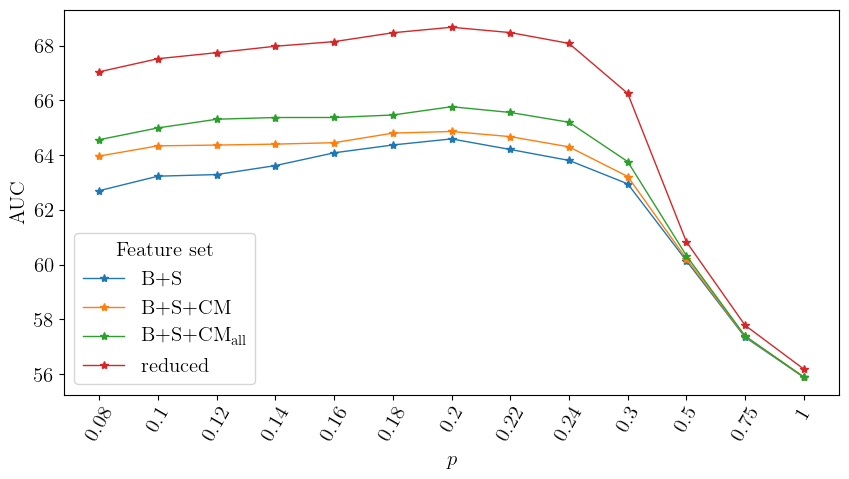

In [9]:
save_dir = os.path.join("../results/novelty")

print(f"\nIterating novelty fraction")
novelty_frac  = 0.5
print(f"-------- Novelty fraction = {novelty_frac}")
general_path = "../data/preprocessed/"
base_name = f"metric_features_novelty_{novelty_frac}_preprocessed_sample_10000_0.012"

# feature sets
plt.figure(figsize = (10,5))
# feature sets
for i, feature_set_name  in enumerate(feature_set_names):
    print("--------- ")
    print(feature_set_name)
    save_name = os.path.join(save_dir,f"RBDA_{feature_set_name}_{base_name}.pkl")
    with open(save_name, 'rb') as file:
        ps, novelty_frac, k, vallofs, testrocaucs, testlofs = pickle.load(file)
    # plot
    plt.plot(np.array(range(len(ps))), np.array(testrocaucs)*100, '-*', label = feature_set_labels[feature_set_name])
plt.legend(title = "Feature set")
plt.ylabel('AUC')
plt.xlabel('$p$')
# plt.xticks(np.arange(0.1, 1.1, 0.1))
plt.xticks(np.array(range(len(ps))), ps, rotation=60)
plt.savefig('../pictures/RBDA_novelty.pdf', bbox_inches='tight')